# Smartech assignment

**By: Gil Zeevi**

In [102]:
#the 'must' packages
import numpy as np
import pandas as pd

 #visualisation
import matplotlib.pylab as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,6)

#Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.metrics import plot_confusion_matrix

#ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_excel('Data.xlsx')

In [4]:
df.head(5)

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Result
0,6,148.0,72.0,35.0,0.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,0.0,26.6,0.351,31,0
2,8,183.0,64.0,0.0,0.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [5]:
df.describe()

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Result
count,756.000000,755.000000,754.000000,754.000000,754.000000,754.000000,756.000000,756.000000,756.000000
mean,3.854497,121.083444,69.108753,20.551724,79.667109,31.988594,0.473336,33.287037,0.349206
std,3.373052,32.055773,19.501390,15.944312,115.435174,7.889383,0.333002,11.772721,0.477035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.374500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,126.750000,36.575000,0.629250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [148]:
df['Result'].value_counts()

0    492
1    264
Name: Result, dtype: int64

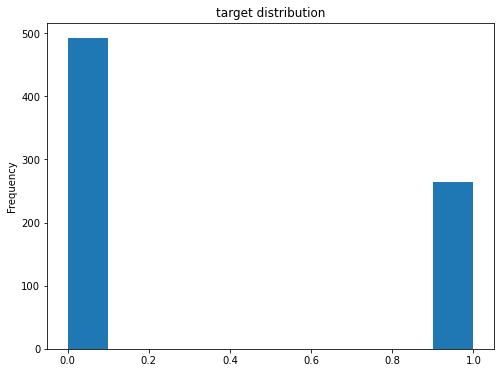

In [6]:
ax = df['Result'].plot(kind = 'hist',title = 'target distribution')

In [7]:
df.isna().sum()

Col_1     0
Col_2     1
Col_3     2
Col_4     2
Col_5     2
Col_6     2
Col_7     0
Col_8     0
Result    0
dtype: int64

In [8]:
x = df.isna().sum()
x[x > 0].index
nan_indices = [[df.loc[pd.isna(df[col]), :].index,int(col.split('_')[1])-1] for col in x[x > 0].index]
nan_indices

[[Int64Index([213], dtype='int64'), 1],
 [Int64Index([312, 603], dtype='int64'), 2],
 [Int64Index([265, 565], dtype='int64'), 3],
 [Int64Index([420, 421], dtype='int64'), 4],
 [Int64Index([231, 659], dtype='int64'), 5]]

There are null samples hence there is a need for imputing - i will use KNN for imputing

In [9]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X = pd.DataFrame(imputer.fit_transform(df.drop(labels = ['Result'],axis = 1)))
X.columns  = df.columns[:-1]
Ximp=X.copy()
X

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0
...,...,...,...,...,...,...,...,...
751,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0
752,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0
753,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0
754,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0


resulted imputed values:

In [10]:
[X.to_numpy()[val] for val in nan_indices]

[array([117.5]),
 array([79., 67.]),
 array([ 0. , 19.5]),
 array([195. ,  33.5]),
 array([41.85, 28.15])]

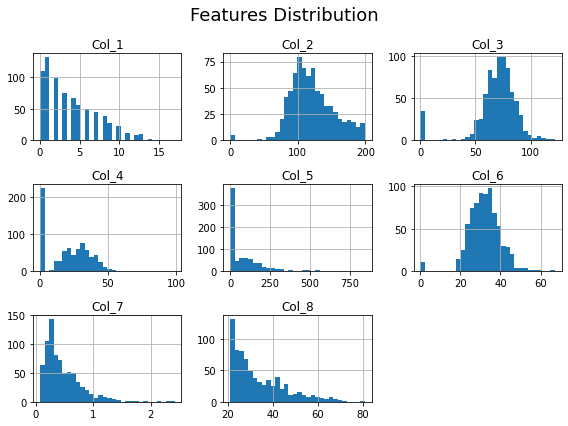

In [154]:
X.hist(bins = 30)
plt.suptitle('Features Distribution',fontsize=18)
plt.tight_layout()
plt.show()

**Removing Quasi-Constant features**

In [12]:
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(X)
# len(train_features.columns[constant_filter.get_support()])
qconstant_filter.fit_transform(X).shape

(756, 8)

In [13]:
qconstant_filter.variances_

array([   11.36242686,  1024.87112054,   378.93027211,   253.77162025,
       13292.80713507,    62.14343394,     0.11074393,   138.41364149])

As seen above, there arent any quasistatic variance features

## OUTLIERS

In [14]:
Xfull = pd.concat([X,df['Result']],axis=1)

<AxesSubplot:>

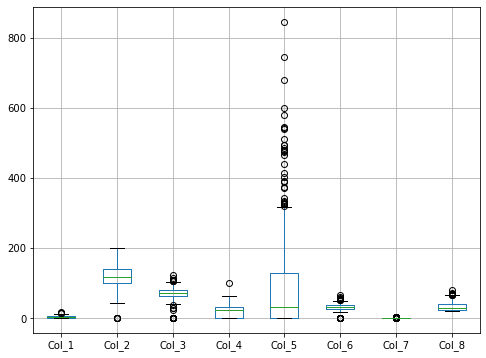

In [15]:
Ximp.boxplot()

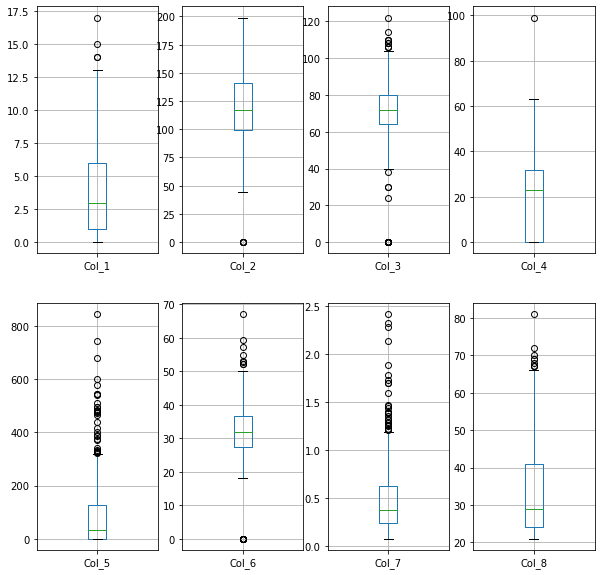

In [16]:
fig, axs = plt.subplots(2, 4,figsize=(10,10))
j=0
for i,col in enumerate(Ximp.columns):
    if i >= 4:
        j=1
        i -=4
    Ximp.boxplot(column = col,ax=axs[j,i])

Removing outliers, IQR based filtering

In [42]:
Xfull = pd.concat([X,df['Result']],axis=1)

### Hard outliers removal

In [44]:
print(f'Data Length before filtering out outliers:{len(Xfull)}\n')
for col in ['Col_4']:
    Q1 = Xfull[col].quantile(0.25)
    Q3 = Xfull[col].quantile(0.75)
    IQR = Q3 - Q1
    Xfull = Xfull[(Q1 - 1.5*IQR <  Xfull[col]) &  ( Xfull[col] < Q3 + 1.5*IQR)]
print(f'Data Length After filtering out outliers:{len(Xfull)}')

Data Length before filtering out outliers:756

Data Length After filtering out outliers:755


Only feature 4 wasn't sensitive to outliers removal. in general outliers removal without prior/domain knowledge might cause more harm than benefit

In [47]:
Ximp,target = Xfull.iloc[:,:-1],Xfull.iloc[:,-1]

# Correlations

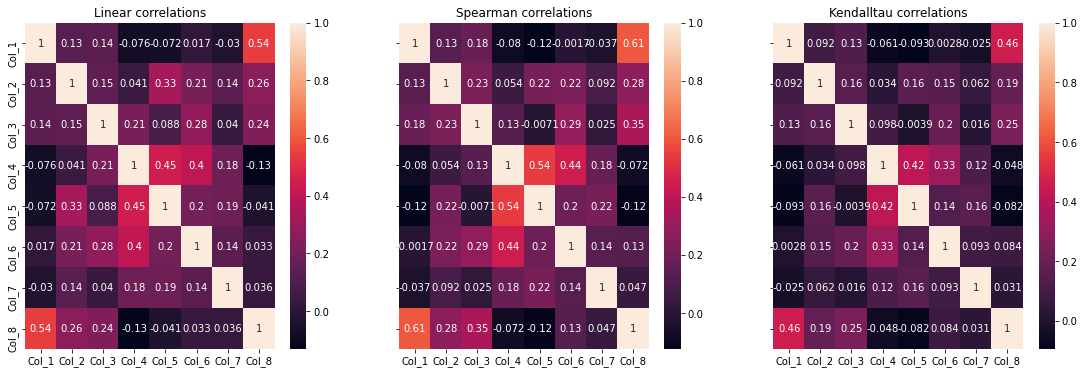

In [48]:
f, axes = plt.subplots(1, 3,figsize=(19,6),sharey=True)
sns.heatmap(Ximp.corr(), annot=True,ax=axes[0]).set_title('Linear correlations')
sns.heatmap(Ximp.corr('spearman'), annot=True,ax=axes[1]).set_title('Spearman correlations')
sns.heatmap(Ximp.corr('kendall'), annot=True,ax=axes[2]).set_title('Kendalltau correlations')
plt.show()

There are correlated features... i will deal with them by picking the best one with Best{Forward, Backward} Selection

# Building inspection pipeline

In [49]:
class ModelExamination():
    def __init__(self, model,X,y,test_size=0.2, random_state=42):
        """
        A class which encapsulate the relevant parameters(mean, cov matrix) for a class conditinoal multi normal distribution.
        The mean and cov matrix (You can use np.cov for this!) will be computed from a given data set.
        
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        self.X= X.copy()
        self.y=y.copy()
        self.test_size=test_size
        self.random_state=random_state
        self.model= model
        self.best_features = X.columns
    
    def split_data(self):
        return train_test_split(self.X[self.best_features], self.y,test_size=self.test_size,random_state=self.random_state)
        
    def backward_selection(self,X_train, X_test, y_train, y_test):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        print('###########################################################################')
        print('#                           backward Selection                            #')
        print('###########################################################################')
        best_features = None
        features = X_train.columns.tolist()
        features_c = features.copy()
        y = y_train.values
        d_back = {}
        for i in range(2,9):
            best_features = None
            features = X_train.columns.tolist()
            features_c = features.copy()
            while len(features) > i:
                max_acc = 0
                for feature in features:
                    features_c.remove(feature)
                    X = X_train[features_c].values
                    Xtst = X_test[features_c].values
                    y_pred = self.model.fit(X, y).predict(Xtst)
                    acc_computed =  metrics.accuracy_score(y_test, y_pred)
                    if acc_computed >= max_acc:
                        max_acc = acc_computed
                        r = feature
                    features_c = features.copy()
                features.remove(r)
            # best_features = features
            d_back[i]=(features,max_acc)
            print(features,max_acc)
        return d_back
        
        
    def forward_selection(self,X_train, X_test, y_train, y_test):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        d_for = {}
        print('###########################################################################')
        print('#                           Forward Selection                             #')
        print('###########################################################################')
        for i in range(2,9):
            best_features = []
            features = X_train.columns.tolist()
            while len(best_features) < i:
                max_acc = 0
                for feature in features:
                    features_c = best_features.copy()
                    features_c.append(feature)
                    X = X_train[features_c].values
                    Xtst = X_test[features_c].values
                    y = y_train.values
                    y_pred = self.model.fit(X, y).predict(Xtst)
                    acc_computed =  metrics.accuracy_score(y_test, y_pred)
                    if acc_computed >= max_acc:
                        max_acc = acc_computed
                        best = feature
                best_features.append(best)
                features.remove(best)
            d_for[i]=(best_features,max_acc)
            print(best_features,max_acc)
        return d_for
        
    def select_Best_features(self):
        X_train, X_test, y_train, y_test = self.split_data()
        d_for = self.forward_selection(X_train, X_test, y_train, y_test)
        X_train, X_test, y_train, y_test = self.split_data()
        d_back = self.backward_selection(X_train, X_test, y_train, y_test)
        for_feat,for_acc= max(d_for.values(), key=lambda sub: sub[1])[0],max(d_for.values(), key=lambda sub: sub[1])[1]
        bac_feat,bac_acc= max(d_back.values(), key=lambda sub: sub[1])[0],max(d_back.values(), key=lambda sub: sub[1])[1]
        print(f'\n\nForward selection best features: {for_feat}\n with accuracy of {for_acc:.3f}\n\n')
        print(f'BackWard selection best features: {bac_feat}\n with accuracy of {bac_acc:.3f}')
        self.best_features = [for_feat,bac_feat][np.argmax([for_acc,bac_acc])] #assign best found features
    
    def evaluate(self):
        X_train, X_test, y_train, y_test = self.split_data()
        y_pred = self.model.fit(X_train, y_train).predict(X_test)
        print('Accuracy= ',metrics.accuracy_score(y_test, y_pred))
        ax = metrics.plot_roc_curve(self.model,X_test,y_test)

        plt.gca().grid(True)
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title(f"{type(self.model).__name__}, ROC Curve")
        plt.show()
        
    def get_metrics(self):
        X_train, X_test, y_train, y_test = self.split_data()
        y_pred_prob= self.model.predict_proba(X_test)[:,1]
        self.fpr , self.tpr, self.thresholds = roc_curve(y_test, y_pred_prob)
        y_pred =  self.model.predict(X_test)
        self.auc= roc_auc_score(y_test, y_pred_prob) # Area under the curve 
        self.acc= metrics.accuracy_score(y_test, y_pred)  # Accuracy
        

# Naive bayes

Accuracy=  0.7814569536423841


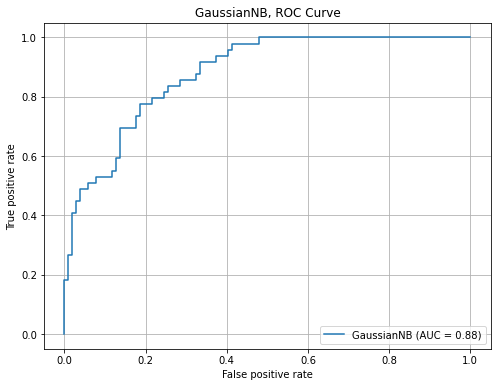

###########################################################################
#                           Forward Selection                             #
###########################################################################
['Col_2', 'Col_6'] 0.8543046357615894
['Col_2', 'Col_6', 'Col_4'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_4', 'Col_1'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_4', 'Col_1', 'Col_5'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_4', 'Col_1', 'Col_5', 'Col_3'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_4', 'Col_1', 'Col_5', 'Col_3', 'Col_8'] 0.8211920529801324
['Col_2', 'Col_6', 'Col_4', 'Col_1', 'Col_5', 'Col_3', 'Col_8', 'Col_7'] 0.7814569536423841
###########################################################################
#                           backward Selection                            #
###########################################################################
['Col_2', 'Col_5'] 0.8278145695364238
['Col_1', 'Col_2', 'Col_5'] 0.8278145695364238
['Co

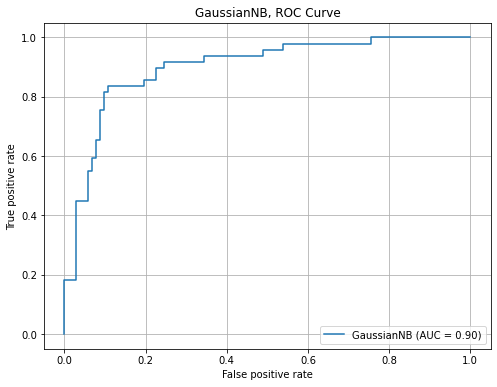

In [50]:
nb=ModelExamination(GaussianNB(),Ximp,target)
nb.evaluate()
nb.select_Best_features()
nb.evaluate()
nb.get_metrics()

# Logistic Regression

Accuracy=  0.7483443708609272


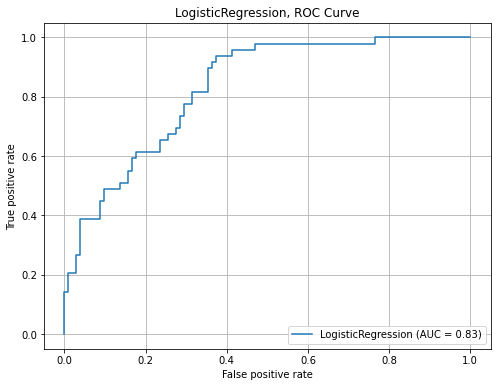

###########################################################################
#                           Forward Selection                             #
###########################################################################
['Col_2', 'Col_6'] 0.8543046357615894
['Col_2', 'Col_6', 'Col_7'] 0.8609271523178808
['Col_2', 'Col_6', 'Col_7', 'Col_4'] 0.847682119205298
['Col_2', 'Col_6', 'Col_7', 'Col_4', 'Col_3'] 0.8543046357615894
['Col_2', 'Col_6', 'Col_7', 'Col_4', 'Col_3', 'Col_1'] 0.8410596026490066
['Col_2', 'Col_6', 'Col_7', 'Col_4', 'Col_3', 'Col_1', 'Col_5'] 0.8145695364238411
['Col_2', 'Col_6', 'Col_7', 'Col_4', 'Col_3', 'Col_1', 'Col_5', 'Col_8'] 0.7483443708609272
###########################################################################
#                           backward Selection                            #
###########################################################################
['Col_2', 'Col_6'] 0.8543046357615894
['Col_2', 'Col_4', 'Col_6'] 0.8609271523178808
['Col

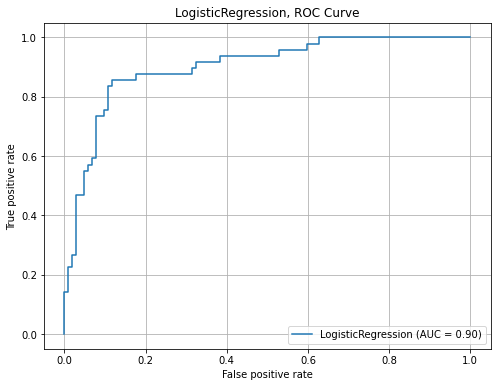

In [51]:
LR=ModelExamination(LogisticRegression(random_state = 42),Ximp,target)
LR.evaluate()
LR.select_Best_features()
LR.evaluate()
LR.get_metrics()

# Decision Tree

Accuracy=  0.7880794701986755


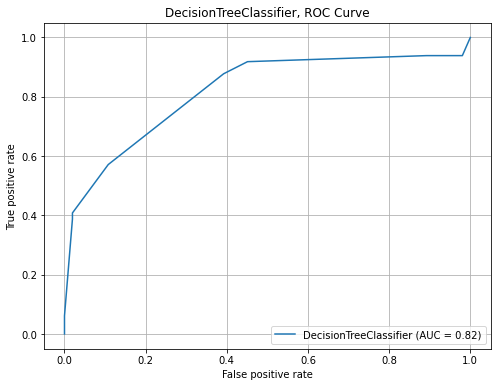

###########################################################################
#                           Forward Selection                             #
###########################################################################
['Col_2', 'Col_4'] 0.8145695364238411
['Col_2', 'Col_4', 'Col_3'] 0.8079470198675497
['Col_2', 'Col_4', 'Col_3', 'Col_5'] 0.8013245033112583
['Col_2', 'Col_4', 'Col_3', 'Col_5', 'Col_6'] 0.7947019867549668
['Col_2', 'Col_4', 'Col_3', 'Col_5', 'Col_6', 'Col_1'] 0.7880794701986755
['Col_2', 'Col_4', 'Col_3', 'Col_5', 'Col_6', 'Col_1', 'Col_7'] 0.7814569536423841
['Col_2', 'Col_4', 'Col_3', 'Col_5', 'Col_6', 'Col_1', 'Col_7', 'Col_8'] 0.7880794701986755
###########################################################################
#                           backward Selection                            #
###########################################################################
['Col_2', 'Col_6'] 0.7880794701986755
['Col_2', 'Col_6', 'Col_7'] 0.7682119205298014
['Co

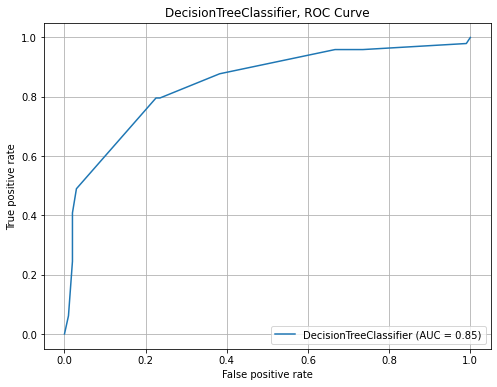

In [159]:
RF=ModelExamination(DecisionTreeClassifier(max_depth=4,random_state=42),Ximp,target)
RF.evaluate()
RF.select_Best_features()
RF.evaluate()
RF.get_metrics()

# Combining all results

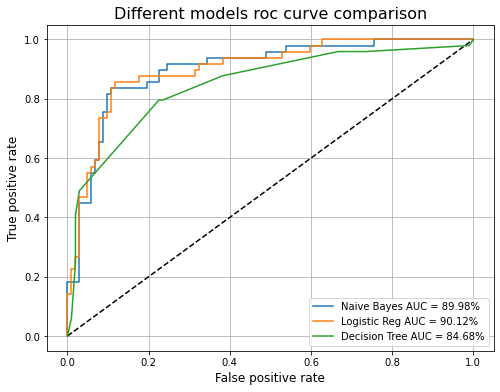

In [161]:

plt.plot([0,1],[0,1], 'k--')
plt.plot(nb.fpr, nb.tpr, label= f"Naive Bayes AUC = {(nb.auc*100):.2f}%")
plt.plot(LR.fpr, LR.tpr, label= f"Logistic Reg AUC = {(LR.auc*100):.2f}%")
plt.plot(RF.fpr, RF.tpr, label= f"Decision Tree AUC = {(RF.auc*100):.2f}%")
# plt.gca().set_xscale("log")
# plt.yticks(np.arange(22) / 20.0)
# plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.title('Different models roc curve comparison',fontsize=16)
plt.legend(loc= 'lower right')
plt.show()

In [162]:
dat=pd.DataFrame(data= [['AUC',nb.auc,LR.auc,RF.auc,'Logistic Regression'],['Accuracy',nb.acc,LR.acc,RF.acc,'Logistic Regression']],columns =  ['metric','NaiveBayes','LogisReg','DecisionTree','Best Model'])
dat.set_index('metric')

,NaiveBayes,LogisReg,DecisionTree,Best Model
metric,,,,
AUC,0.899760,0.901160,0.846839,Logistic Regression
Accuracy,0.854305,0.860927,0.814570,Logistic Regression


# Ensemble methods:

Accuracy=  0.8145695364238411


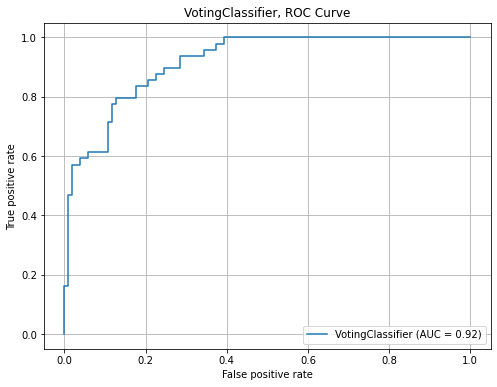

###########################################################################
#                           Forward Selection                             #
###########################################################################
['Col_2', 'Col_6'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_8'] 0.8543046357615894
['Col_2', 'Col_6', 'Col_8', 'Col_3'] 0.8741721854304636
['Col_2', 'Col_6', 'Col_8', 'Col_3', 'Col_1'] 0.8807947019867549
['Col_2', 'Col_6', 'Col_8', 'Col_3', 'Col_1', 'Col_7'] 0.8609271523178808
['Col_2', 'Col_6', 'Col_8', 'Col_3', 'Col_1', 'Col_7', 'Col_5'] 0.8410596026490066
['Col_2', 'Col_6', 'Col_8', 'Col_3', 'Col_1', 'Col_7', 'Col_5', 'Col_4'] 0.8079470198675497
###########################################################################
#                           backward Selection                            #
###########################################################################
['Col_2', 'Col_6'] 0.8344370860927153
['Col_2', 'Col_6', 'Col_8'] 0.8675496688741722
['Co

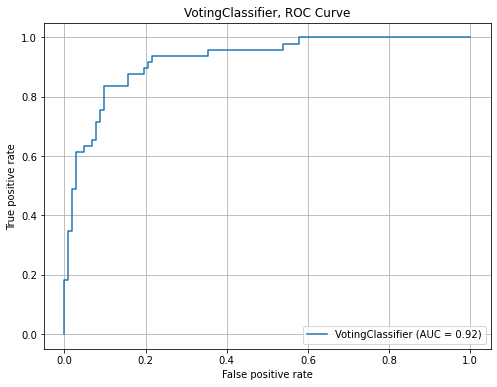

In [105]:
clf1 = DecisionTreeClassifier(max_depth=4,random_state=42)
clf2 = KNeighborsClassifier(n_neighbors=15)
clf3 = SVC(kernel='rbf', probability=True,random_state=42)
clf4 =CatBoostClassifier(verbose=0,n_estimators=100,random_state=42)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3),('cat',clf4)], voting='soft', weights=[1, 2, 1,2])
vot=ModelExamination(eclf,Ximp,target)
vot.evaluate()
vot.select_Best_features()
b.evaluate()

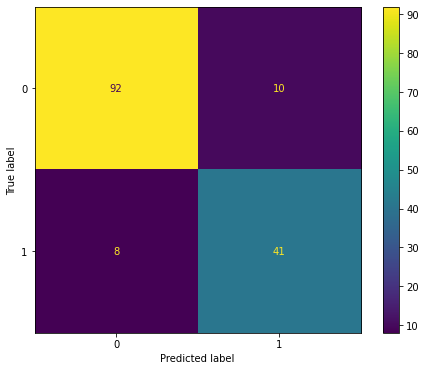

In [108]:
plot_confusion_matrix(eclf, X_test, y_test)

In [164]:
vot.get_metrics()

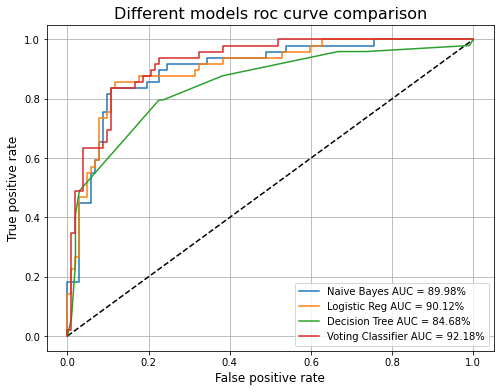

In [167]:

plt.plot([0,1],[0,1], 'k--')
plt.plot(nb.fpr, nb.tpr, label= f"Naive Bayes AUC = {(nb.auc*100):.2f}%")
plt.plot(LR.fpr, LR.tpr, label= f"Logistic Reg AUC = {(LR.auc*100):.2f}%")
plt.plot(RF.fpr, RF.tpr, label= f"Decision Tree AUC = {(RF.auc*100):.2f}%")
plt.plot(vot.fpr, vot.tpr, label= f"Voting Classifier AUC = {(vot.auc*100):.2f}%")
# plt.gca().set_xscale("log")
# plt.yticks(np.arange(22) / 20.0)
# plt.xlim([4e-5, 1.0])
plt.gca().grid(True)
plt.xlabel("False positive rate",fontsize=12)
plt.ylabel("True positive rate",fontsize=12)
plt.title('Different models roc curve comparison',fontsize=16)
plt.legend(loc= 'lower right')
plt.show()